In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from tensorflow import keras 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 

import warnings
warnings.filterwarnings('ignore')

In [2]:
from skimage.morphology import disk
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
kernel = np.ones((5,5),np.uint8)
selem = disk(6)

# **Reading Image Data and Morphological Filters**

In [3]:
labels = ['Negative', 'Positive']
img_size = 120

# Function for reading Images from a folder
def read_images(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

######                 ----- Morphological filters -----Uncomment one of the filter for preprocessing

#                 img_arr = closing(img_arr, selem)
#                 img_arr = skeletonize(img_arr == 0)
#                 img_arr = white_tophat(img_arr, selem)
#                 img_arr = erosion(img_arr, selem)
#                 img_arr = dilation(img_arr, selem)
#                 img_arr = opening(img_arr, selem)
#                 img_arr = black_tophat(img_arr, selem)
#                 img_arr = cv2.morphologyEx(img_arr, cv2.MORPH_GRADIENT, kernel)

                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                type(img_arr)
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
# Calling function for Reading images data in folder with labels
Dataset = read_images('Desktop/dataset')

# **Fetching Folder**

In [5]:
positive_dir = Path('Desktop/dataset/Positive')
negative_dir = Path('Desktop/dataset/Negative')

# **Creating DataFrames**

In [6]:
#Funtion for generting dataframe
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [7]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(all_df)

                                Filepath     Label
0     Desktop\dataset\Negative\-0572.jpg  NEGATIVE
1     Desktop\dataset\Negative\-0569.jpg  NEGATIVE
2     Desktop\dataset\Negative\-0201.jpg  NEGATIVE
3     Desktop\dataset\Positive\-0112.jpg  POSITIVE
4     Desktop\dataset\Positive\-0562.jpg  POSITIVE
...                                  ...       ...
1983  Desktop\dataset\Negative\-0814.jpg  NEGATIVE
1984  Desktop\dataset\Negative\-0113.jpg  NEGATIVE
1985  Desktop\dataset\Negative\-0955.jpg  NEGATIVE
1986  Desktop\dataset\Positive\-0236.jpg  POSITIVE
1987  Desktop\dataset\Negative\-0074.jpg  NEGATIVE

[1988 rows x 2 columns]


In [12]:
# Splitting data for training and testing rendomly.
# change sample size in sample method according to dataset/
train_df, test_df = train_test_split(
    all_df.sample(1988, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# **Generating Image Data**

In [13]:
# Generate batches of tensor image data with real-time data augmentation.
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# **Spliting Train and Test**

In [14]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 1113 validated image filenames belonging to 2 classes.
Found 278 validated image filenames belonging to 2 classes.
Found 597 validated image filenames belonging to 2 classes.


# **Applying CNN Model**

In [15]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(32,3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Conv2D(64,3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Conv2D(128,3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0     

# **Training**

In [16]:
optmzr = Adam(lr=1e-5)

model.compile(loss="binary_crossentropy", optimizer=optmzr, metrics=["accuracy"]) 

history = model.fit(train_data,validation_data=val_data,epochs=110,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=3,
                    restore_best_weights=True)]
)

Epoch 1/110
35/35 [==============================] - 21s 321ms/step - loss: 0.7166 - accuracy: 0.4780 - val_loss: 0.7029 - val_accuracy: 0.5180
Epoch 2/110
35/35 [==============================] - 8s 236ms/step - loss: 0.7002 - accuracy: 0.4780 - val_loss: 0.6903 - val_accuracy: 0.5180
Epoch 3/110
35/35 [==============================] - 8s 223ms/step - loss: 0.6870 - accuracy: 0.6226 - val_loss: 0.6801 - val_accuracy: 0.6691
Epoch 4/110
35/35 [==============================] - 9s 245ms/step - loss: 0.6763 - accuracy: 0.6640 - val_loss: 0.6721 - val_accuracy: 0.6367
Epoch 5/110
35/35 [==============================] - 7s 215ms/step - loss: 0.6679 - accuracy: 0.6424 - val_loss: 0.6648 - val_accuracy: 0.6295
Epoch 6/110
35/35 [==============================] - 7s 203ms/step - loss: 0.6602 - accuracy: 0.6406 - val_loss: 0.6570 - val_accuracy: 0.6439
Epoch 7/110
35/35 [==============================] - 7s 206ms/step - loss: 0.6514 - accuracy: 0.6649 - val_loss: 0.6477 - val_accuracy: 0.651

Epoch 58/110
35/35 [==============================] - 2s 61ms/step - loss: 0.4279 - accuracy: 0.7835 - val_loss: 0.4264 - val_accuracy: 0.7878
Epoch 59/110
35/35 [==============================] - 2s 61ms/step - loss: 0.4264 - accuracy: 0.7862 - val_loss: 0.4244 - val_accuracy: 0.7950
Epoch 60/110
35/35 [==============================] - 2s 62ms/step - loss: 0.4253 - accuracy: 0.7871 - val_loss: 0.4232 - val_accuracy: 0.7950
Epoch 61/110
35/35 [==============================] - 2s 61ms/step - loss: 0.4238 - accuracy: 0.7925 - val_loss: 0.4277 - val_accuracy: 0.8058
Epoch 62/110
35/35 [==============================] - 2s 62ms/step - loss: 0.4222 - accuracy: 0.7907 - val_loss: 0.4214 - val_accuracy: 0.8058
Epoch 63/110
35/35 [==============================] - 2s 61ms/step - loss: 0.4204 - accuracy: 0.7942 - val_loss: 0.4209 - val_accuracy: 0.8165
Epoch 64/110
35/35 [==============================] - 2s 61ms/step - loss: 0.4192 - accuracy: 0.7880 - val_loss: 0.4205 - val_accuracy: 0.8165

# **Showing Loss and Accuracy in Graph**

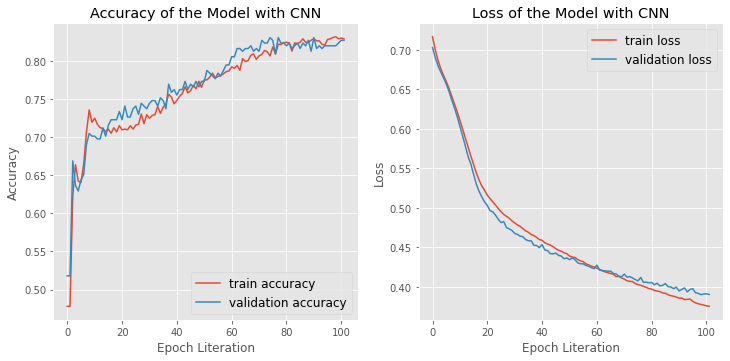

In [17]:
plt.figure(figsize=(12, 12))
plt.style.use("ggplot")
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model with CNN')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch Literation', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model with CNN')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch Literation', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

# **Results & Classification Report**

In [18]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n=====================================================\n", clr)

    Test Loss: 0.43109
Test Accuracy: 79.56%


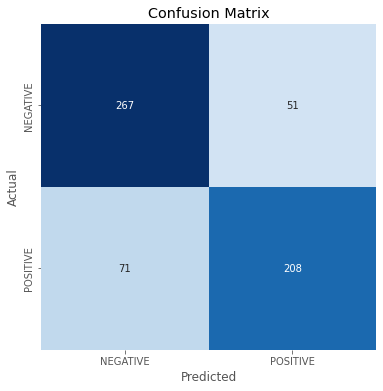

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.79      0.84      0.81       318
    POSITIVE       0.80      0.75      0.77       279

    accuracy                           0.80       597
   macro avg       0.80      0.79      0.79       597
weighted avg       0.80      0.80      0.79       597



In [19]:
evaluate_model(model, test_data)

# **Checking Image Sample**

In [22]:
image = tf.keras.preprocessing.image.load_img("Desktop/dataset/Positive/-0079.jpg", target_size=(120, 120))

In [23]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr]) 

In [24]:
input_arr = input_arr.astype('float32') / 255.

In [25]:
predictions = model.predict(input_arr)

In [26]:
print("Result:\n======================\n")
if(predictions[0]>=0.5):
    print("Crack Detected")
else:
    print("No Crack Detected")

Result:

Crack Detected


# **Showing loaded image in multiple vision**

Visualizing Sample Image in Threshold, Canny & Contours



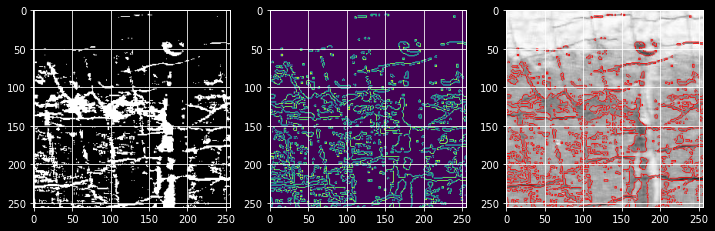

In [28]:
plt.style.use("dark_background")
figure,axis = plt.subplots(nrows=1,ncols=3,figsize=(12,12))

Reading_Img = cv2.imread("Desktop/dataset/Positive/-0079.jpg", cv2.IMREAD_GRAYSCALE)
Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)

_,Threshold_Img = cv2.threshold(Reading_Img,150,255,cv2.THRESH_BINARY_INV)
Canny_Img = cv2.Canny(Threshold_Img,90,100)
contours,_ = cv2.findContours(Canny_Img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
Draw_Contours = cv2.drawContours(Reading_Img,contours,-1,(255,0,0),1)

axis[0].imshow(Threshold_Img)
axis[1].imshow(Canny_Img)
axis[2].imshow(Draw_Contours)

print("Visualizing Sample Image in Threshold, Canny & Contours\n=====================================================\n")